In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/bradhakrishnan/ECE276A_PR2/code")
data_base_path= "/home/bradhakrishnan/ECE276A_PR2/data/"

In [3]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import expm
import jax
import matplotlib.pyplot as plt
import load_data 

jax.config.update("jax_enable_x64", True)
dataset_idx =20


In [4]:
(encoder_counts, encoder_ts,
lidar_angle_min, lidar_angle_max, lidar_angle_increment,
lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps,
imu_angular, imu_linear, imu_ts,
disp_stamps, rgb_stamps) = load_data.load_dataset(dataset_idx)

In [5]:
def velocity_calculator(encoder_data, encoder_ts):
    #skipping the 0th index
    del_ts= encoder_ts[1:] - encoder_ts[:-1]
    VL = 0.5*jnp.sum(encoder_data[[0, 2], 1:], axis=0)*0.0022/del_ts
    VR = 0.5*np.sum(encoder_data[[1, 3], 1:], axis=0)*0.0022/del_ts
    robo_vel = (VL+VR)/2
    return robo_vel
    
robo_vel=velocity_calculator(encoder_counts, encoder_ts)


In [6]:
def twist_creator(lin_vel, ang_vel):
    # Create a 4x4 matrix of zeros
    twist = np.zeros((4, 4))
    
    # Set the last column to lin_vel (with a zero appended at the end)
    vel_x= lin_vel
    vel_y= 0
    vel_z=0
    twist[0:3, 3] = np.array([vel_x, vel_y, vel_z])
    
    # Set the element at first row, second column to -ang_vel[2]
    twist[0, 1] = -ang_vel[2]
    
    # Set the element at second row, first column to the third element of lin_vel
    twist[1, 0] = ang_vel[2]
    
    return twist

In [7]:
def time_sync(time_stamp_1, time_stamp_2):
    ts_synced = {}
    for ts in time_stamp_1:
        ts_synced[ts] = np.argmin(np.abs(ts-time_stamp_2))
    return ts_synced

imu_sync_map= time_sync(encoder_ts, imu_ts)
lidar_sync_map = time_sync(encoder_ts, lidar_stamps)

disp_sync_map= time_sync(encoder_ts, disp_stamps)
rgb_sync_map= time_sync(encoder_ts, rgb_stamps)

In [8]:
def motion_model(prev_pose, lin_vel, angular_vel,del_T):
    twist= twist_creator(lin_vel,angular_vel)
    pred_T= prev_pose@expm(del_T* twist)
    return pred_T
    

# ENCODER - IMU Robot trajectory. 

In [9]:
T_0= jnp.eye(4)
encoder_poses= [T_0]
del_ts= encoder_ts[1:] - encoder_ts[:-1]
for ii in range(0,encoder_counts.shape[-1]-1):
    ang_vel= imu_angular[:,imu_sync_map[encoder_ts[ii]]]
    lin_vel= robo_vel[ii]
    del_T= del_ts[ii]
    encoder_poses.append(motion_model(encoder_poses[ii],lin_vel, ang_vel, del_T))
encoder_poses= np.array(encoder_poses)

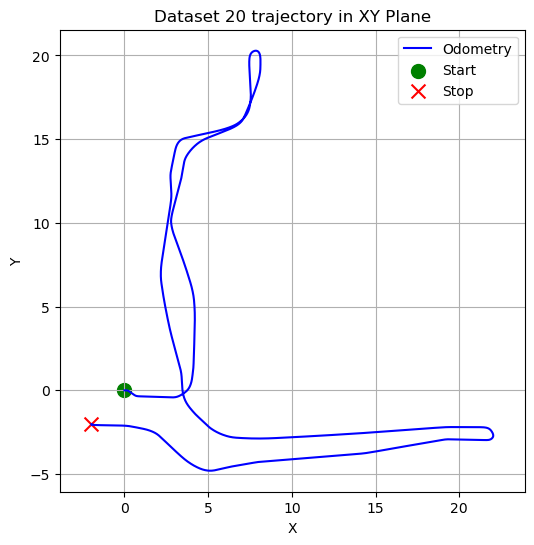

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory(poses, additional_poses=None, title="Trajectory in XY Plane", f_traj_name="Trajectory 1", s_traj_name="Trajectory 2"):
    """
    Plots the trajectory of a sequence of poses in the XY plane.

    Parameters:
    - poses: A list or array of transformation matrices (4x4) for the first trajectory.
    - additional_poses: An optional list or array of transformation matrices (4x4) for the second trajectory.
    - title: Title for the plot (default: "Trajectory in XY Plane").
    - f_traj_name: Label for the first trajectory (default: "Trajectory 1").
    - s_traj_name: Label for the second trajectory (default: "Trajectory 2").
    """
    # Extract XY positions from the transformation matrices
    xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in poses])
    
    # Create the plot
    plt.figure(figsize=(6, 6))
    
    # Plot the first trajectory
    plt.plot(xy_positions[:, 0], xy_positions[:, 1], label=f_traj_name, color='blue')
    plt.scatter(xy_positions[0, 0], xy_positions[0, 1], color='green', label=f'Start', s=100, marker='o')
    plt.scatter(xy_positions[-1, 0], xy_positions[-1, 1], color='red', label=f'Stop', s=100, marker='x')

    # If additional trajectory is provided, plot it
    if additional_poses is not None:
        additional_xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in additional_poses])
        plt.plot(additional_xy_positions[:, 0], additional_xy_positions[:, 1], label=s_traj_name, color='orange')
        plt.scatter(additional_xy_positions[0, 0], additional_xy_positions[0, 1], color='green', label=f'Start', s=100, marker='o')
        plt.scatter(additional_xy_positions[-1, 0], additional_xy_positions[-1, 1], color='red', label=f'Stop', s=100, marker='x')

    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes.
    plt.legend()
    plt.savefig(f"./outputs/{title}.png", bbox_inches='tight')

    plt.show()

plot_trajectory(encoder_poses, title=f"Dataset {dataset_idx} trajectory in XY Plane", f_traj_name="Odometry")


# ICP SCAN MATCHING

In [10]:
def get_lidar_pc(lidar_raw_vals,  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment):
    lidar_angles= np.linspace(lidar_angle_min, lidar_angle_max, int((lidar_angle_max - lidar_angle_min) / lidar_angle_increment) + 1)
    lidar_val_mask = np.where((lidar_raw_vals > lidar_range_min) & (lidar_raw_vals < lidar_range_max), True, False)
    lidar_raw_vals_masked = lidar_raw_vals[lidar_val_mask]
    lidar_angles_masked = lidar_angles[lidar_val_mask]
    lidar_x = lidar_raw_vals_masked * np.cos(lidar_angles_masked) 
    lidar_y = lidar_raw_vals_masked * np.sin(lidar_angles_masked)
    lidar_z = np.zeros(lidar_raw_vals_masked.shape[0])
    return np.column_stack((lidar_x,lidar_y,lidar_z))

In [11]:
import ICP_stuff
from tqdm import tqdm
accumulated_pose = np.identity(4)
icp_traj = []
relative_poses=[]
lidar_body_pose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))

for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts_at_t = encoder_ts[idx]
    enc_ts_at_t1 = encoder_ts[idx+1]
    encoder_pred_poses = encoder_poses[idx]

    # LTDAR stuff at time t
    lidar_range_val_at_t = lidar_ranges[:, lidar_sync_map[enc_ts_at_t]]
    lidar_pc_at_t = get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t = encoder_poses[idx] @ lidar_body_pose

    # LTDAR stuff at time t+1
    lidar_range_val_at_t1 = lidar_ranges[:, lidar_sync_map[enc_ts_at_t1]]  
    lidar_pc_at_t1 = get_lidar_pc(lidar_range_val_at_t1,lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t1 = encoder_poses[idx+1] @ lidar_body_pose

    init_pose_for_ICP = np.linalg.inv(pose_at_t) @ pose_at_t1

    icp_estimated_pose = ICP_stuff.ICP(lidar_pc_at_t, lidar_pc_at_t1, init_pose_for_ICP, filter_dist_threshold=0.5)

    accumulated_pose = accumulated_pose @ icp_estimated_pose
    relative_poses.append(icp_estimated_pose)
    icp_traj.append(accumulated_pose)

icp_traj = np.array(icp_traj)
relative_poses = np.array(relative_poses)

100%|██████████| 4955/4955 [01:33<00:00, 52.98it/s]


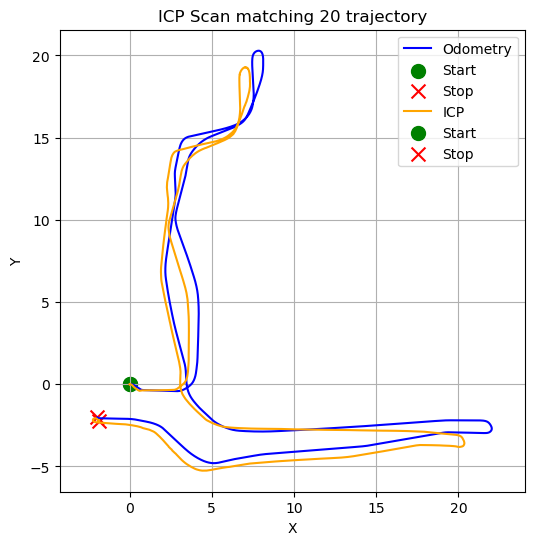

In [13]:
plot_trajectory(encoder_poses,icp_traj, title=f"ICP Scan matching {dataset_idx} trajectory", f_traj_name="Odometry", s_traj_name="ICP")


# Occupancy Grid

In [17]:
import numpy as np
import pr2_utils
# Initialize a grid map
MAP = {}
MAP['res'] = np.array([0.05, 0.05])    # meters
MAP['min'] = np.array([-20.0, -20.0])  # meters
MAP['max'] = np.array([30.0, 30.0])    # meters
MAP['size'] = np.ceil((MAP['max'] - MAP['min']) / MAP['res']).astype(int)
isEven = MAP['size']%2==0
MAP['size'][isEven] = MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
MAP['map'] = np.zeros(MAP['size'])

In [23]:
def get_map_coords(xy, MAP):
    return np.floor((xy - MAP['min']) / MAP['res']).astype(int)

In [19]:
for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts = encoder_ts[idx]
    curr_pose= icp_traj[idx] @ lidar_body_pose
    
    curr_R, curr_p= ICP_stuff.get_R_and_P(curr_pose)

    lidar_range_val = lidar_ranges[:, lidar_sync_map[enc_ts]]
    lidar_pc= get_lidar_pc(lidar_range_val, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    lidar_pc= ICP_stuff.rotate_pc(R=curr_R, pc=lidar_pc)+curr_p
    
    lidar_xy_pts= lidar_pc[:,:2]

    lidar_grid_pts= get_map_coords(lidar_xy_pts, MAP)-1
    
    lidar_grid_x= lidar_grid_pts[:,0]
    lidar_grid_y= lidar_grid_pts[:,1]

    start_pt=get_map_coords(curr_p[:2],MAP)

    for ii in range(lidar_grid_x.shape[0]):
        x,y = pr2_utils.bresenham2D(start_pt[0],start_pt[1], lidar_grid_x[ii], lidar_grid_y[ii])
        MAP['map'][y.astype(np.int32)[:-1], x.astype(np.int32)[:-1]] -= np.log(4)

    MAP['map'][lidar_grid_y, lidar_grid_x] += np.log(4)

    MAP['map'][np.where(MAP['map'] < -4*np.log(4))] = -4*np.log(4)
    MAP['map'][np.where(MAP['map'] > 4*np.log(4))] = 4*np.log(4)

100%|██████████| 4955/4955 [06:36<00:00, 12.48it/s]


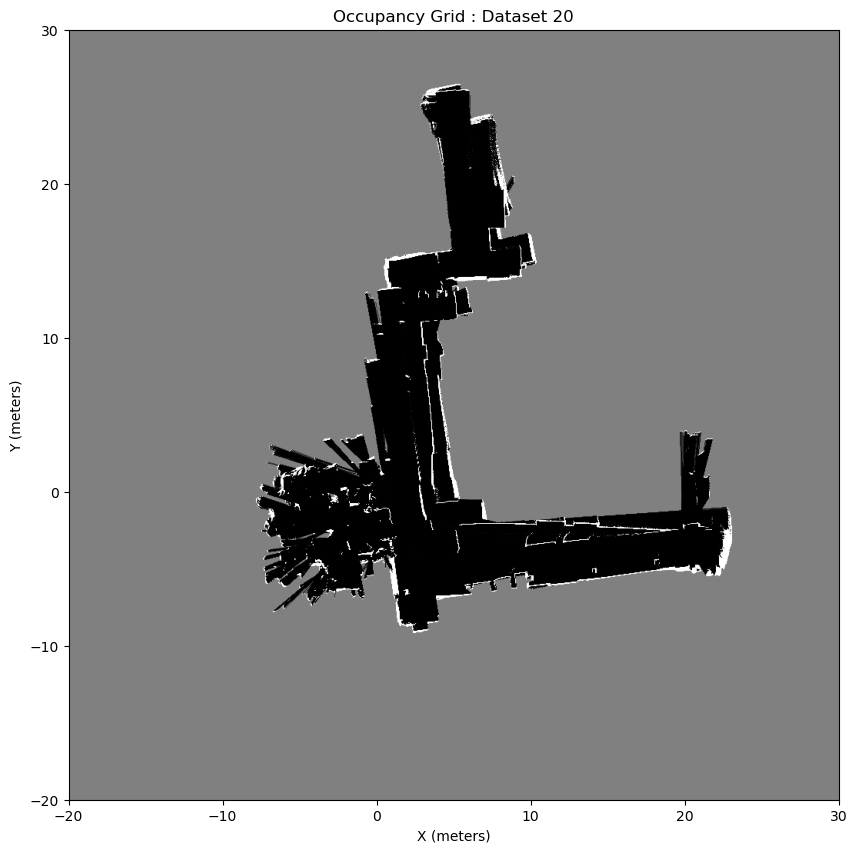

In [20]:
plt.figure(figsize=(10, 10))
plt.title(f'Occupancy Grid : Dataset {dataset_idx}')
plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray', origin='lower', extent=[MAP['min'][0], MAP['max'][0], MAP['min'][1], MAP['max'][1]])

# Set axis labels with scale information
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Save and display
plt.savefig('./outputs/ICP_occupancy_grid_{}.jpg'.format(dataset_idx))
plt.show()


# Texture Mapping

In [21]:
import ICP_stuff
import transforms3d as t3d
import cv2
# Initialize a grid map
TEXTURE_MAP = {}
TEXTURE_MAP['res'] = np.array([0.05, 0.05])    # meters
TEXTURE_MAP['min'] = np.array([-20.0, -20.0])  # meters
TEXTURE_MAP['max'] = np.array([30.0, 30.0])    # meters
TEXTURE_MAP['size'] = np.ceil((TEXTURE_MAP['max'] - TEXTURE_MAP['min']) / TEXTURE_MAP['res']).astype(int)
isEven = TEXTURE_MAP['size']%2==0
TEXTURE_MAP['size'][isEven] = TEXTURE_MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
TEXTURE_MAP['map'] = np.zeros((TEXTURE_MAP['size'][0], TEXTURE_MAP['size'][1], 3))

In [29]:
for idx in tqdm(range(encoder_ts.shape[0]-1)):
    
    icp_pose= icp_traj[idx]
    enc_ts = encoder_ts[idx]
    
    rgb_file_num= rgb_sync_map[enc_ts]+1
    bgr_img = cv2.imread(f"../data/dataRGBD/RGB{dataset_idx}/rgb{dataset_idx}_{rgb_file_num}.png")
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    disp_file_num = disp_sync_map[enc_ts]+1
    disp_img = cv2.imread(f"../data/dataRGBD/Disparity{dataset_idx}/disparity{dataset_idx}_{disp_file_num}.png", cv2.IMREAD_UNCHANGED)
    height, width = disp_img.shape
    dd = np.array(-0.00304 * disp_img + 3.31)
    depth = 1.03 / dd

    mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
    i_idxs = mesh[0].flatten()
    j_idxs = mesh[1].flatten()
    
    rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
    rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

    # some may be out of bounds, just clip them
    rgb_i = np.clip(rgb_i, 0, height - 1)
    rgb_j = np.clip(rgb_j, 0, width - 1)
    
    colors = rgb_img[rgb_i, rgb_j]
    # colors = colors / 255
    uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])

    K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])
 
    uv1= depth.flatten() * (np.linalg.inv(K) @ uv1) # rotate the given point by K^-1
    oRr = np.array([[0, -1, 0],
                [0, 0, -1],
                [1, 0, 0]])
    # we want rRo because we have points in optical frame and want to move them to the regular frame.
    points = oRr.T @ uv1
    points_homogeneous = np.vstack([points, np.ones(points.shape[1])])
    # now do cam -> body stuff
    cam2body_p= np.array([0.18,0.005,0.36])
    cam2body_R = t3d.euler.euler2mat(0,0.36,0.021)
    cam2body_T= ICP_stuff.get_pose(cam2body_R, cam2body_p)
    points_body = cam2body_T @ points_homogeneous
    

    points_world = icp_pose @ points_body
    uv_body_xy = points_world[:2, :].T
    uv_body_z = points_world[2, :]

    norms = np.linalg.norm(points_world[:3, :], axis=0)
    
    valid_indices = np.where((uv_body_z < 0.5))

    # if valid_indices[0].shape[0] ==0:
    #     import ipdb; ipdb.set_trace()
    #     print(valid_indices)
    uv_body_xy = uv_body_xy[valid_indices]
    colors = colors[valid_indices]/255.0

    # Map world coordinates to grid indices
    grid_xy = np.round((uv_body_xy - TEXTURE_MAP['min']) / TEXTURE_MAP['res']).astype(int)
    grid_x, grid_y = grid_xy[:, 0], grid_xy[:, 1]

    # Filter valid grid indices
    valid_mask = (grid_x >= 0) & (grid_x < TEXTURE_MAP['size'][0]) & \
                 (grid_y >= 0) & (grid_y < TEXTURE_MAP['size'][1])
    grid_x, grid_y, colors = grid_x[valid_mask], grid_y[valid_mask], colors[valid_mask]

    # Update the texture map
    TEXTURE_MAP['map'][grid_y, grid_x] = colors
    # texture_map_xy = get_map_coords(uv_body_xy, TEXTURE_MAP)
    # TEXTURE_MAP['map'][texture_map_xy[:,1], texture_map_xy[:,0], :] = colors
    if idx==10:
        continue

100%|██████████| 4955/4955 [14:15<00:00,  5.79it/s]


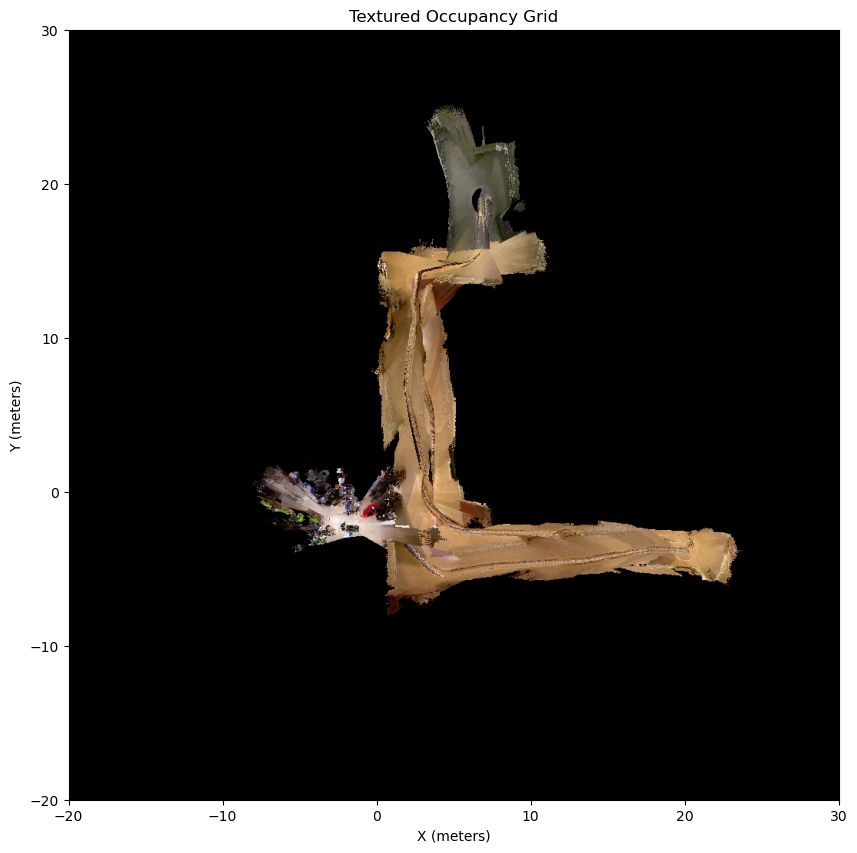

In [30]:
import datetime

plt.figure(figsize=(10, 10))
plt.title('Textured Occupancy Grid')
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

plt.imshow(TEXTURE_MAP['map'], origin='lower', extent=[TEXTURE_MAP['min'][0], TEXTURE_MAP['max'][0], TEXTURE_MAP['min'][1], TEXTURE_MAP['max'][1]])

# Set axis labels with scale information
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Save and display
plt.savefig('./outputs/Textured_occupancy_{}_{}.jpg'.format(dataset_idx, timestamp))
plt.show()

# GTSAM 

In [12]:
import gtsam
import numpy as np
from gtsam import Pose3, Point3, Rot3
poses = encoder_poses          # List of 4x4 absolute transformation matrices
relative_poses = relative_poses  # List of 4x4 relative transformations (ICP-based)

def matrix_to_pose3(T):
    R, p = ICP_stuff.get_R_and_P(T)
    return Pose3(Rot3(R), Point3(p))

# Initialize the factor graph and initial values
factor_graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Define noise models
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])  # Small uncertainty
#odometry_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])  # Odometry uncertainty <=> icp noise
# odometry_noise = gtsam.noiseModel.Diagonal.Sigmas([0.01, 0.01, 0.01, 0.1, 0.1, 0.1])
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas([0.2, 0.2, 0.2, 0.3, 0.3, 0.3])

loop_closure_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1]*6))  # Higher confidence
# make pos noise small

In [13]:
first_pose = matrix_to_pose3(poses[0])
factor_graph.add(gtsam.PriorFactorPose3(0, first_pose, prior_noise))
initial_estimate.insert(0, first_pose)

In [14]:
for i in range(1, len(poses)):
    relative_pose = matrix_to_pose3(relative_poses[i-1])  # Convert relative transform
    factor_graph.add(gtsam.BetweenFactorPose3(i-1, i, relative_pose, odometry_noise))
    initial_estimate.insert(i, matrix_to_pose3(poses[i]))  # Insert estimated absolute pose

In [15]:
fixed_interval = 10
edges_added_from_fixed=0
edges_added_from_proximity = 0
dist_ls= []
for i in range(1, len(poses)):
    if i % fixed_interval == 0:
        dist_ls= []
        j = i - fixed_interval
        curr_ts= encoder_ts[i] 
        prev_10_ts= encoder_ts[j]
        curr_lidar_pc= get_lidar_pc(lidar_ranges[:,lidar_sync_map[curr_ts]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
        prev_10_lidar_pc= get_lidar_pc(lidar_ranges[:,lidar_sync_map[prev_10_ts]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
        curr_pose=(poses[i]@lidar_body_pose)
        prev_10_pose= (poses[j]@lidar_body_pose)
        ICP_init= np.linalg.inv(poses[i]) @ poses[j]     
        ICP_pred, dist= ICP_stuff.ICP(source_pc= curr_lidar_pc, target_pc=prev_10_lidar_pc,init_T=ICP_init,filter_dist_threshold=2, return_dist= True) 
        # print(np.linalg.norm(ICP_pred[:3,3]))
        if np.linalg.norm(ICP_pred[:3,3])<0.01:
            edges_added_from_fixed+=1
            factor_graph.add(gtsam.BetweenFactorPose3(i, j, matrix_to_pose3(ICP_pred), loop_closure_noise))
         
    for k in range(1, i - 200, 10):
        past_pose = (poses[k]@lidar_body_pose)
        rel_pose= np.linalg.inv(curr_pose)@past_pose
        pose_diff= np.linalg.norm(rel_pose[:3,3])
        dist_ls.append(pose_diff)
        if pose_diff<1e-3:
            past_pose_lidar_pc= get_lidar_pc(lidar_ranges[:,lidar_sync_map[encoder_ts[k]]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
            ICP_pred, dist= ICP_stuff.ICP(source_pc= curr_lidar_pc, target_pc=past_pose_lidar_pc,init_T=rel_pose,filter_dist_threshold=2, return_dist= True) 
            if  np.linalg.norm(ICP_pred[:3,3])<0.001:
                edges_added_from_proximity+=1
                factor_graph.add(gtsam.BetweenFactorPose3(i, j, matrix_to_pose3(ICP_pred), loop_closure_noise))
                                        

final_pose_idx = len(poses) - 1
ICP_init = np.linalg.inv(poses[0]@lidar_body_pose) @ (poses[final_pose_idx]@lidar_body_pose)# Transformation from last to first pose
init_pc=get_lidar_pc(lidar_ranges[:,lidar_sync_map[encoder_ts[0]]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
final_pc=get_lidar_pc(lidar_ranges[:,lidar_sync_map[encoder_ts[final_pose_idx]]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])

ICP_pred, dist= ICP_stuff.ICP(source_pc= init_pc, target_pc=final_pc,init_T=ICP_init,filter_dist_threshold=2, return_dist= True) 
factor_graph.add(gtsam.BetweenFactorPose3(0,final_pose_idx, matrix_to_pose3(ICP_pred), loop_closure_noise))


8.841471065253403
7.752458771387722
8.319057546877524
7.890013468908766
7.788504929747678
7.750465631235298
8.16467390243264
8.181469808693421
8.166404337294605
7.672672225718222
7.304544520218419
7.775134022117552
8.618989283230023
8.1173311886802
7.95803707707748
7.742149074698652
8.358384076735254
7.610137194871422
7.654554382698632
7.778843159573109
8.124715223431346
8.239581480294323
7.868266181626783
7.787890831875929
7.3909548832163745
7.802126061991878
7.7818225090294
7.70102008055336
7.663050948952304
7.764511311738631
8.068289140755486
7.875765572154906
7.11889476777311
7.816164156134164
8.025708877704462
7.835306519153499
7.798387447213312
8.203467017411157
8.608108327202686
16.046445284073016
9.269866466348747
8.332334737962679
8.147148529920713
7.722642457861857
10.924799337101863
8.116269923876851
8.08662139062531
10.429598302469422
8.257571589824737
8.552655837478222
9.108383115626904
11.480300173591305
8.680019226570835
8.587837086821624
7.806164812292704
7.620539641235

In [16]:
# Step 3: Optimize the Graph
params = gtsam.LevenbergMarquardtParams()
params.setMaxIterations(4000)
optimizer = gtsam.LevenbergMarquardtOptimizer(factor_graph, initial_estimate, params)
result = optimizer.optimize()

In [17]:
optimized_poses = []

for i in range(len(poses)):  # Iterate over all pose indices
    optimized_pose = result.atPose3(i)  # Get optimized Pose3
    T = np.eye(4)  # Initialize 4x4 matrix

    # Extract rotation and translation from Pose3
    T[:3, :3] = optimized_pose.rotation().matrix()
    T[:3, 3] = optimized_pose.translation()

    optimized_poses.append(T)

# Now, optimized_poses is a list of 4x4 matrices
optimized_poses= np.array(optimized_poses)


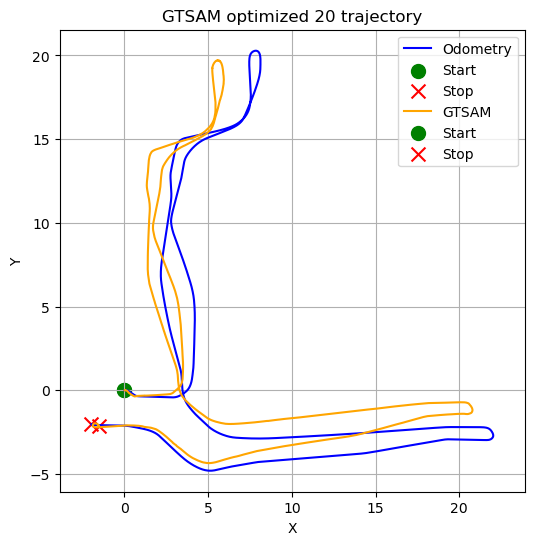

In [20]:
plot_trajectory(encoder_poses,optimized_poses, title=f"GTSAM optimized {dataset_idx} trajectory", f_traj_name="Odometry", s_traj_name="GTSAM")

# GTSAM OCCUPANCY

In [21]:
import numpy as np
import pr2_utils
# Initialize a grid map
MAP = {}
MAP['res'] = np.array([0.05, 0.05])    # meters
MAP['min'] = np.array([-20.0, -20.0])  # meters
MAP['max'] = np.array([30.0, 30.0])    # meters
MAP['size'] = np.ceil((MAP['max'] - MAP['min']) / MAP['res']).astype(int)
isEven = MAP['size']%2==0
MAP['size'][isEven] = MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
MAP['map'] = np.zeros(MAP['size'])

In [24]:
for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts = encoder_ts[idx]
    curr_pose= optimized_poses[idx] @ lidar_body_pose
    
    curr_R, curr_p= ICP_stuff.get_R_and_P(curr_pose)

    lidar_range_val = lidar_ranges[:, lidar_sync_map[enc_ts]]
    lidar_pc= get_lidar_pc(lidar_range_val, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    lidar_pc= ICP_stuff.rotate_pc(R=curr_R, pc=lidar_pc)+curr_p
    
    lidar_xy_pts= lidar_pc[:,:2]

    lidar_grid_pts= get_map_coords(lidar_xy_pts, MAP)-1
    
    lidar_grid_x= lidar_grid_pts[:,0]
    lidar_grid_y= lidar_grid_pts[:,1]

    start_pt=get_map_coords(curr_p[:2],MAP)

    for ii in range(lidar_grid_x.shape[0]):
        x,y = pr2_utils.bresenham2D(start_pt[0],start_pt[1], lidar_grid_x[ii], lidar_grid_y[ii])
        MAP['map'][y.astype(np.int32)[:-1], x.astype(np.int32)[:-1]] -= np.log(4)

    MAP['map'][lidar_grid_y, lidar_grid_x] += np.log(4)

    MAP['map'][np.where(MAP['map'] < -4*np.log(4))] = -4*np.log(4)
    MAP['map'][np.where(MAP['map'] > 4*np.log(4))] = 4*np.log(4)

100%|██████████| 4955/4955 [12:41<00:00,  6.51it/s]


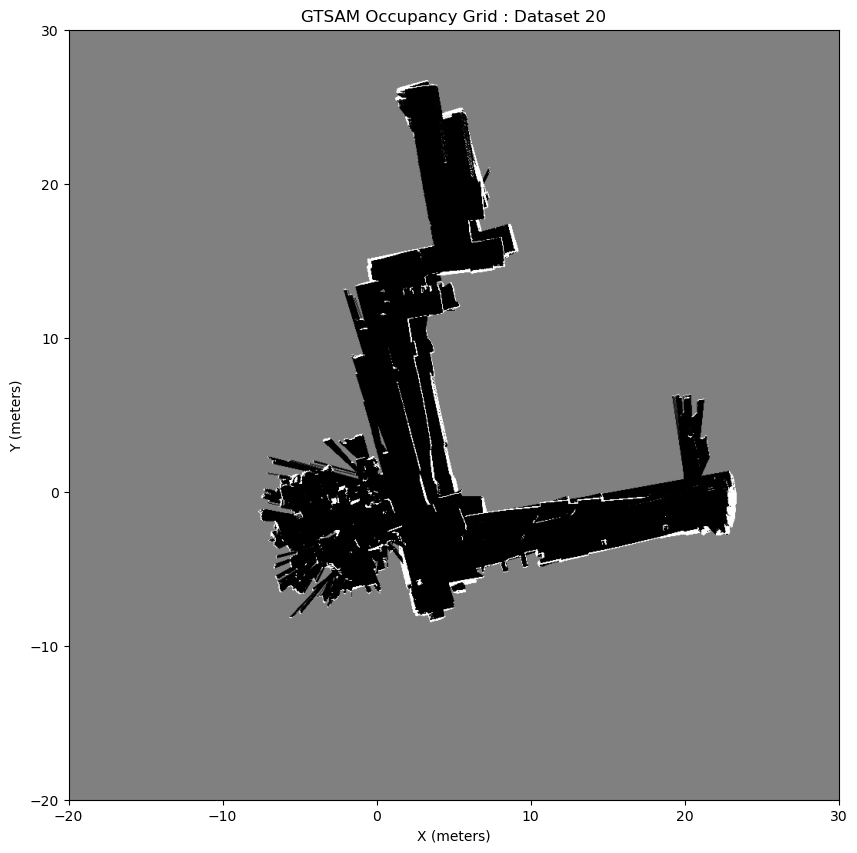

In [25]:
plt.figure(figsize=(10, 10))
plt.title(f'GTSAM Occupancy Grid : Dataset {dataset_idx}')
plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray', origin='lower', extent=[MAP['min'][0], MAP['max'][0], MAP['min'][1], MAP['max'][1]])

# Set axis labels with scale information
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Save and display
plt.savefig('./outputs/GTSAM_occupancy_grid_{}.jpg'.format(dataset_idx))
plt.show()


In [26]:
import ICP_stuff
import transforms3d as t3d
import cv2
# Initialize a grid map
TEXTURE_MAP = {}
TEXTURE_MAP['res'] = np.array([0.05, 0.05])    # meters
TEXTURE_MAP['min'] = np.array([-20.0, -20.0])  # meters
TEXTURE_MAP['max'] = np.array([30.0, 30.0])    # meters
TEXTURE_MAP['size'] = np.ceil((TEXTURE_MAP['max'] - TEXTURE_MAP['min']) / TEXTURE_MAP['res']).astype(int)
isEven = TEXTURE_MAP['size']%2==0
TEXTURE_MAP['size'][isEven] = TEXTURE_MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
TEXTURE_MAP['map'] = np.zeros((TEXTURE_MAP['size'][0], TEXTURE_MAP['size'][1], 3))

In [27]:

for idx in tqdm(range(encoder_ts.shape[0]-1)):
    icp_pose= optimized_poses[idx]
    enc_ts = encoder_ts[idx]
    
    rgb_file_num= rgb_sync_map[enc_ts]+1
    bgr_img = cv2.imread(f"../data/dataRGBD/RGB{dataset_idx}/rgb{dataset_idx}_{rgb_file_num}.png")
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    disp_file_num = disp_sync_map[enc_ts]+1
    disp_img = cv2.imread(f"../data/dataRGBD/Disparity{dataset_idx}/disparity{dataset_idx}_{disp_file_num}.png", cv2.IMREAD_UNCHANGED)
    height, width = disp_img.shape
    dd = np.array(-0.00304 * disp_img + 3.31)
    depth = 1.03 / dd

    mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
    i_idxs = mesh[0].flatten()
    j_idxs = mesh[1].flatten()
    
    rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
    rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

    # some may be out of bounds, just clip them
    rgb_i = np.clip(rgb_i, 0, height - 1)
    rgb_j = np.clip(rgb_j, 0, width - 1)
    
    colors = rgb_img[rgb_i, rgb_j]
    # colors = colors / 255
    uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])

    K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])
 
    uv1= depth.flatten() * (np.linalg.inv(K) @ uv1) # rotate the given point by K^-1
    oRr = np.array([[0, -1, 0],
                [0, 0, -1],
                [1, 0, 0]])
    # we want rRo because we have points in optical frame and want to move them to the regular frame.
    points = oRr.T @ uv1
    points_homogeneous = np.vstack([points, np.ones(points.shape[1])])
    # now do cam -> body stuff
    cam2body_p= np.array([0.18,0.005,0.36])
    cam2body_R = t3d.euler.euler2mat(0,0.36,0.021)
    cam2body_T= ICP_stuff.get_pose(cam2body_R, cam2body_p)
    points_body = cam2body_T @ points_homogeneous
    

    points_world = icp_pose @ points_body
    uv_body_xy = points_world[:2, :].T
    uv_body_z = points_world[2, :]

    norms = np.linalg.norm(points_world[:3, :], axis=0)
    
    valid_indices = np.where((uv_body_z < 0.5))

    # if valid_indices[0].shape[0] ==0:
    #     import ipdb; ipdb.set_trace()
    #     print(valid_indices)
    uv_body_xy = uv_body_xy[valid_indices]
    colors = colors[valid_indices]/255.0

    # Map world coordinates to grid indices
    grid_xy = np.round((uv_body_xy - TEXTURE_MAP['min']) / TEXTURE_MAP['res']).astype(int)
    grid_x, grid_y = grid_xy[:, 0], grid_xy[:, 1]

    # Filter valid grid indices
    valid_mask = (grid_x >= 0) & (grid_x < TEXTURE_MAP['size'][0]) & \
                 (grid_y >= 0) & (grid_y < TEXTURE_MAP['size'][1])
    grid_x, grid_y, colors = grid_x[valid_mask], grid_y[valid_mask], colors[valid_mask]

    # Update the texture map
    TEXTURE_MAP['map'][grid_y, grid_x] = colors
    # texture_map_xy = get_map_coords(uv_body_xy, TEXTURE_MAP)
    # TEXTURE_MAP['map'][texture_map_xy[:,1], texture_map_xy[:,0], :] = colors
    if idx==10:
        continue

100%|██████████| 4955/4955 [15:36<00:00,  5.29it/s]


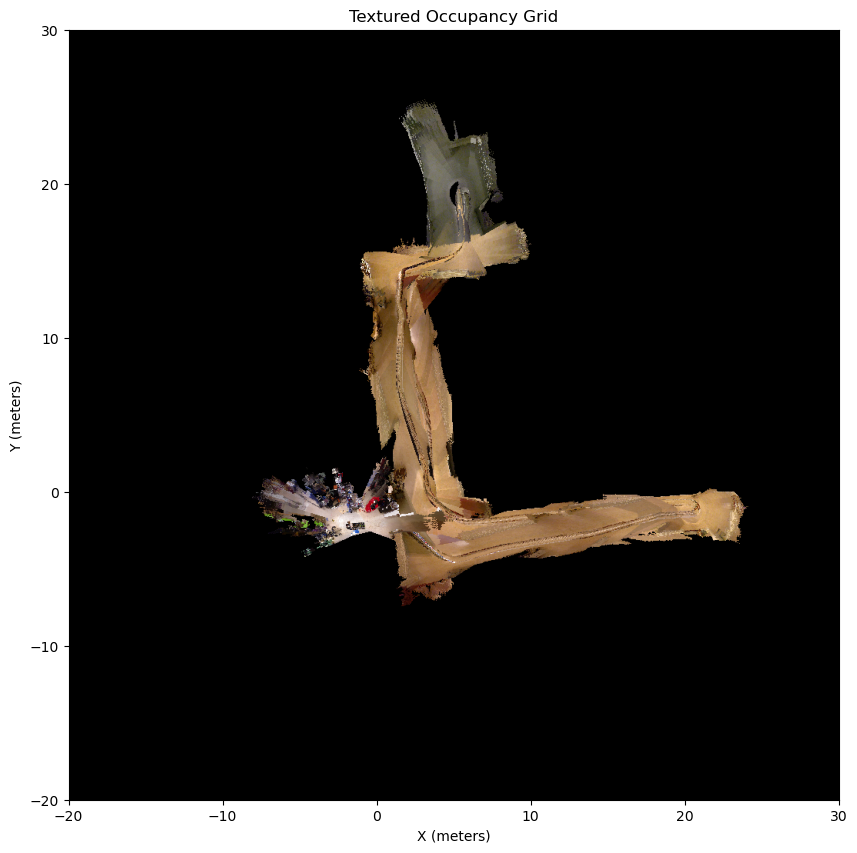

In [29]:
import datetime

plt.figure(figsize=(10, 10))
plt.title('Textured Occupancy Grid')
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

plt.imshow(TEXTURE_MAP['map'], origin='lower', extent=[TEXTURE_MAP['min'][0], TEXTURE_MAP['max'][0], TEXTURE_MAP['min'][1], TEXTURE_MAP['max'][1]])

# Set axis labels with scale information
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Save and display
plt.savefig('./outputs/GTSAM_Textured_occupancy_{}_{}.jpg'.format(dataset_idx, timestamp))
plt.show()